In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.stats import t

In [77]:
def read_tsp_file(file_path):
    """Reads a TSP file in TSPLIB format and extracts city coordinates."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coords_start = lines.index("NODE_COORD_SECTION\n") + 1
    coords_end = lines.index("EOF\n")
    coords = []

    for line in lines[coords_start:coords_end]:
        parts = line.split()
        coords.append((float(parts[1]), float(parts[2])))

    return coords

coord = read_tsp_file("a280.tsp.txt")

In [78]:
# Calculate pairwise distances
def calculate_distance_matrix(coords):
    n = len(coords)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i, j] = math.sqrt((coords[i][0] - coords[j][0])**2 +
                                                 (coords[i][1] - coords[j][1])**2)
    return distance_matrix

dist_matrix = calculate_distance_matrix(coord)

In [79]:
# Calculate total path length
def total_path_length(path, distance_matrix):
    return sum(distance_matrix[path[i - 1], path[i]] for i in range(len(path)))

In [80]:
# 2-opt move by reconnecting cities
def two_opt_reconnect(route, i, k):
    """
    Perform a 2-opt move by reconnecting the route without swapping the cities directly.
    Deletes two non-adjacent edges and reconnects them to form a new valid circuit.
    
    Args:
        route: A list representing the current route (list of city indices).
        i: Index of the first edge to be deleted.
        k: Index of the second edge to be deleted (k > i).
    
    Returns:
        A new route after performing the 2-opt move.
    """
    # Ensure i and k are valid
    if i >= k or i < 0 or k >= len(route):
        raise ValueError("Invalid indices for 2-opt move")
    
    # Reconnect the path
    new_route = route[:i + 1] + route[k:i:-1] + route[k + 1:]
    return new_route


In [81]:
# Cooling Strategies
def geometric_cooling(temp, cooling_rate):
    return temp * cooling_rate

def linear_cooling(temp, cooling_rate):
    return temp - cooling_rate

def logarithmic_cooling(temp, iteration):
    return temp / math.log(iteration + 1)

def exponential_cooling(temp, cooling_rate, iteration):
    return temp * np.exp(-cooling_rate * iteration)

In [82]:
# Simulated Annealing
def simulated_annealing(distance_matrix, initial_temp, cooling_strategy, markov_length, max_iter=500, cooling_factor=None):
    n = len(distance_matrix)
    current_solution = list(range(n))
    random.shuffle(current_solution)
    current_cost = total_path_length(current_solution, distance_matrix)
   
    best_solution = current_solution
    best_cost = current_cost

    temperature = initial_temp
    iteration = 1

    while temperature > 1e-3:
        for _ in range(markov_length):
            i, k = sorted(random.sample(range(n), 2))  # Random indices for 2-opt
            new_solution = two_opt_reconnect(current_solution, i, k)
            new_cost = total_path_length(new_solution, distance_matrix)

            if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost) / temperature):
                current_solution = new_solution
                current_cost = new_cost

                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost

        if cooling_strategy == "geometric_cooling_strategy":  
            new_temperature = geometric_cooling(temperature, cooling_factor)
        elif cooling_strategy == "linear_cooling_strategy":
            new_temperature = linear_cooling(temperature, cooling_factor)
        elif cooling_strategy == "logarithmic_cooling_strategy":
            new_temperature = logarithmic_cooling(initial_temp, iteration)
        elif cooling_strategy == "exponential_cooling_strategy":
            new_temperature = exponential_cooling(initial_temp, cooling_factor, iteration)

        temperature = new_temperature
        iteration += 1
        if iteration > max_iter:
            break

    return best_solution, best_cost

In [2]:
def compute_confidence_interval(data, confidence=0.95):
    """Computes the confidence interval for a given dataset."""
    mean = np.mean(data)
    n = len(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    margin_of_error = std_err * t.ppf((1 + confidence) / 2, df=n-1)
    return mean, mean - margin_of_error, mean + margin_of_error

In [83]:
# Parameters
initial_temp = 1000
cooling_rate = 0.995
markov_length = 100
max_iter = 100000

# Run the algorithm
best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "geometric_cooling_strategy" , markov_length, max_iter, cooling_rate)

# Output the results
print("Best Solution:", best_solution)
print("Best Cost:", best_cost)

Best Solution: [127, 20, 130, 19, 131, 132, 18, 17, 23, 22, 24, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 36, 49, 50, 48, 51, 52, 53, 46, 47, 38, 39, 40, 41, 45, 54, 55, 68, 69, 70, 71, 65, 66, 67, 57, 56, 44, 43, 58, 62, 63, 64, 84, 83, 85, 115, 112, 86, 87, 82, 72, 73, 75, 74, 76, 77, 78, 80, 81, 88, 89, 79, 92, 93, 94, 95, 96, 97, 91, 90, 103, 107, 108, 109, 111, 110, 113, 114, 116, 117, 61, 60, 59, 42, 119, 118, 156, 157, 158, 159, 174, 160, 181, 182, 183, 184, 162, 161, 173, 172, 106, 105, 104, 102, 101, 100, 98, 99, 167, 168, 169, 170, 171, 166, 165, 164, 163, 187, 188, 186, 185, 189, 190, 191, 192, 197, 196, 193, 194, 195, 200, 201, 199, 198, 144, 145, 142, 143, 202, 203, 204, 211, 212, 215, 216, 214, 217, 219, 220, 221, 218, 222, 223, 224, 225, 226, 233, 234, 235, 232, 231, 236, 237, 230, 245, 238, 239, 244, 240, 242, 241, 1, 0, 279, 2, 3, 278, 277, 247, 243, 246, 249, 250, 229, 228, 227, 213, 210, 209, 206, 205, 207, 252, 208, 251, 254, 248, 255, 253, 256, 257, 258, 

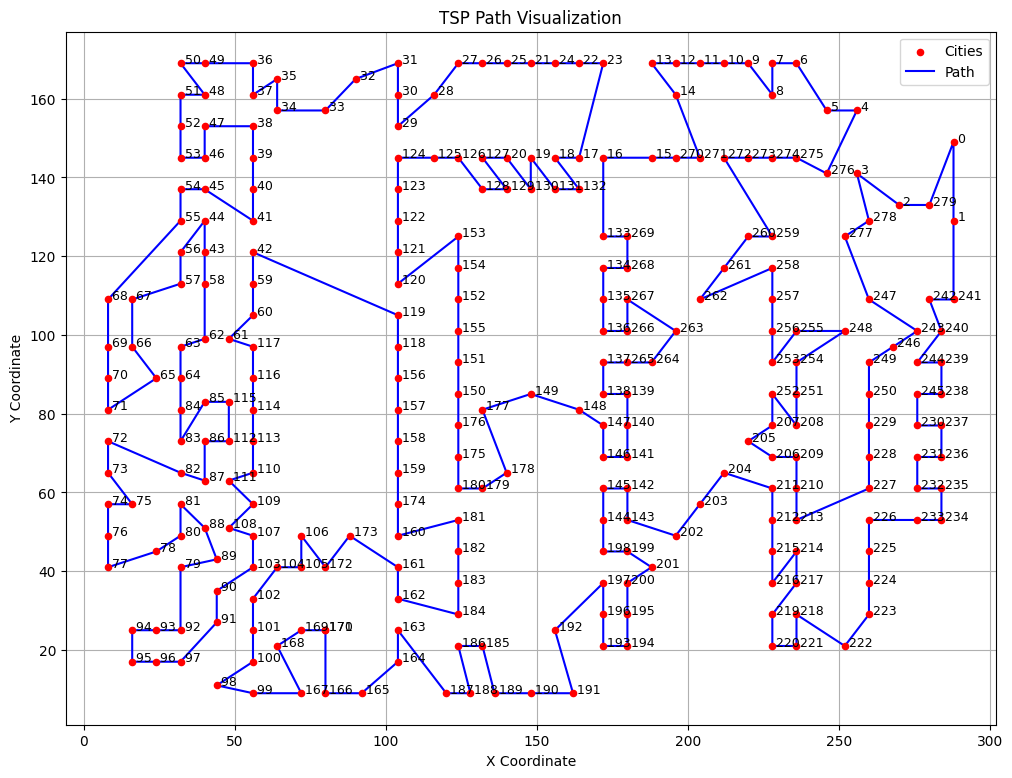

In [84]:
def plot_tsp_path(cities, route):
    """
    Plot the cities and the path connecting them.
    
    Args:
        cities: A list of tuples representing the coordinates of cities (e.g., [(x1, y1), (x2, y2), ...]).
        route: A list of indices representing the order in which cities are visited.
    """
    # Extract coordinates in the order of the route
    x_coords = [cities[i][0] for i in route] + [cities[route[0]][0]]
    y_coords = [cities[i][1] for i in route] + [cities[route[0]][1]]
    
    # Plot cities
    plt.figure(figsize=(12, 9))
    plt.scatter(*zip(*cities), color='red', s = 20, label='Cities', zorder=3)
    for idx, (x, y) in enumerate(cities):
        plt.text(x, y, f' {idx}', fontsize=9, zorder=4)
    
    # Plot the path
    plt.plot(x_coords, y_coords, color='blue', linestyle='-', linewidth=1.5, label='Path', zorder=2)
    
    # Add details
    plt.title("TSP Path Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_tsp_path(coord, best_solution)

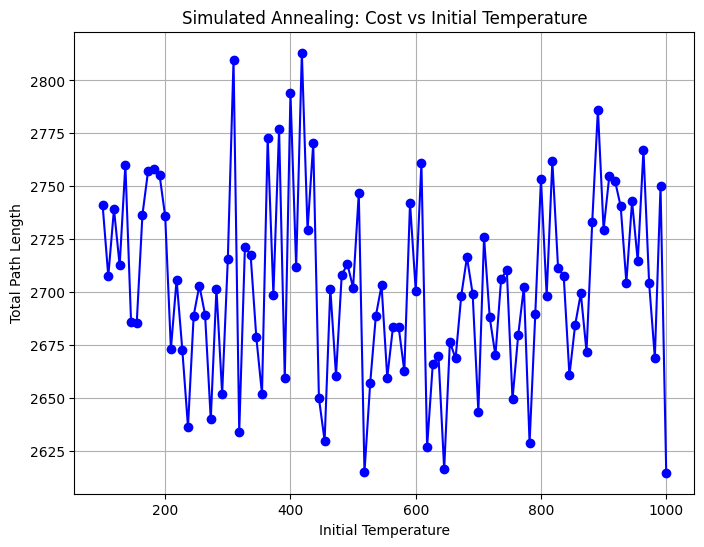

In [85]:
# Parameters
initial_temp = np.linspace(100, 1000, 100)
cost_temp = []
sol_temp = []
cooling_rate = 0.999
markov_length = 605
max_iter = 10000


for temp in initial_temp:
    best_solution, best_cost = simulated_annealing(dist_matrix, temp, "geometric_cooling_strategy", markov_length, max_iter, cooling_rate)
    sol_temp.append(best_solution)
    cost_temp.append(best_cost)

plt.figure(figsize=(8, 6))
plt.plot(initial_temp, cost_temp, marker='o', color='blue')
plt.title("Simulated Annealing: Cost vs Initial Temperature")
plt.xlabel("Initial Temperature")
plt.ylabel("Total Path Length")
plt.grid(True)
plt.show()


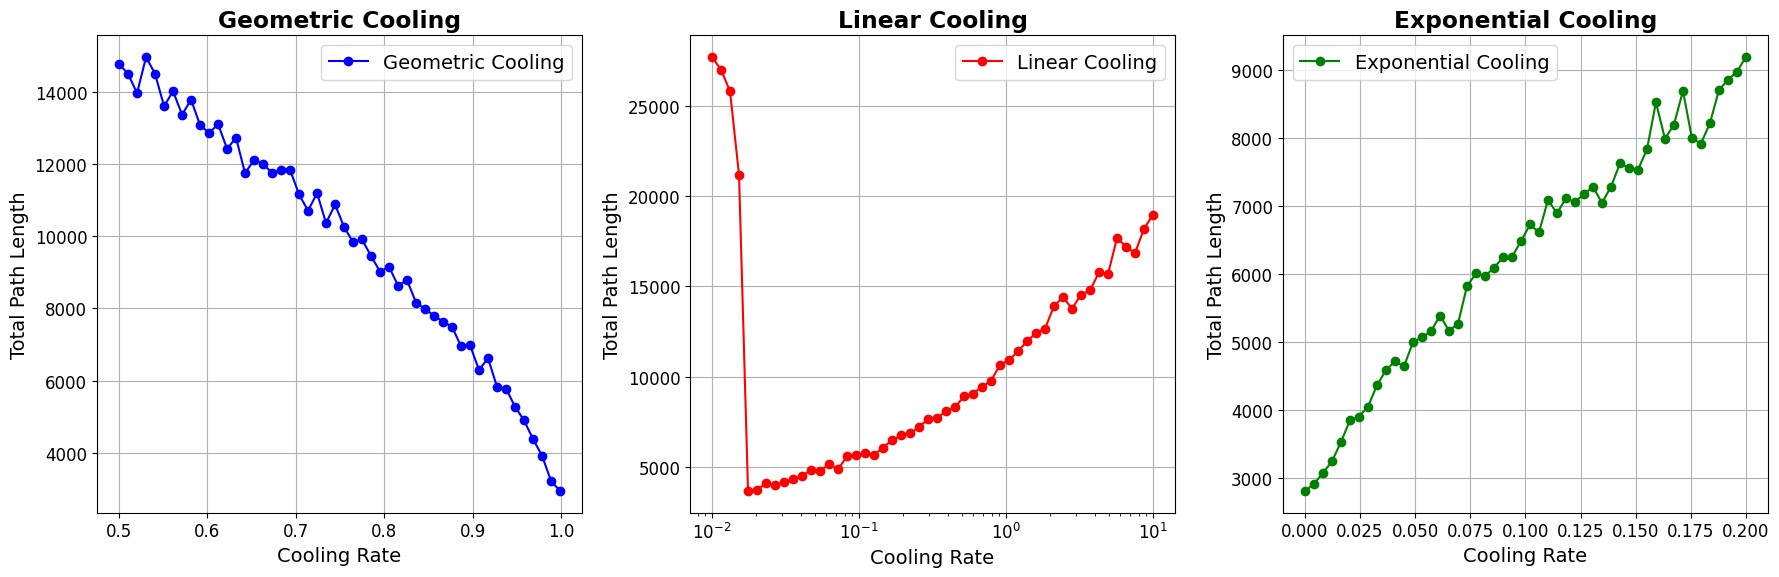

Geometric Cooling: Best Cost: 2943.1425913434637
Linear Cooling: Best Cost: 3661.362477194358
Exponential Cooling: Best Cost: 2815.9089133542234
Logarithmic Cooling: Best Cost: 20730.81968434069


In [86]:
# Parameters
initial_temp = 1000
markov_length = 100
max_iter = 60000

# Geomnetric Cooling
rates_geo = np.linspace(0.5, 0.999, 50)
cost_geo = []
sol_geo = []

# Linear Cooling
rates_linear = np.logspace(-2, 1, 50)
cost_linear = []
sol_linear = []

# Exponential Cooling
rates_exp = np.linspace(0.0001, 0.2, 50)
cost_exp = []
sol_exp = []

for rate in rates_geo:
    best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "geometric_cooling_strategy", markov_length, max_iter ,rate)
    sol_geo.append(best_solution)
    cost_geo.append(best_cost)

for rate in rates_linear:
    best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "linear_cooling_strategy", markov_length, max_iter, rate)
    sol_linear.append(best_solution)
    cost_linear.append(best_cost)

for rate in rates_exp:
    best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "exponential_cooling_strategy", markov_length, max_iter, rate)
    sol_exp.append(best_solution)
    cost_exp.append(best_cost)

best_solution, cost_log = simulated_annealing(dist_matrix, initial_temp, "logarithmic_cooling_strategy", markov_length, max_iter)

plt.rcParams['font.size'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Geometric Cooling
axes[0].plot(rates_geo, cost_geo, marker='o', color='blue', label='Geometric Cooling')
axes[0].set_title("Geometric Cooling")
axes[0].set_xlabel("Cooling Rate")
axes[0].set_ylabel("Total Path Length")
axes[0].legend()
axes[0].grid(True)

# Linear Cooling
axes[1].semilogx(rates_linear, cost_linear, marker='o', color='red', label='Linear Cooling')
axes[1].set_title("Linear Cooling")
axes[1].set_xlabel("Cooling Rate")
axes[1].set_ylabel("Total Path Length")
axes[1].legend()
axes[1].grid(True)

# Exponential Cooling
axes[2].plot(rates_exp, cost_exp, marker='o', color='green', label='Exponential Cooling')
axes[2].set_title("Exponential Cooling")
axes[2].set_xlabel("Cooling Rate")
axes[2].set_ylabel("Total Path Length")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("Geometric Cooling: Best Cost:", min(cost_geo))
print("Linear Cooling: Best Cost:", min(cost_linear))
print("Exponential Cooling: Best Cost:", min(cost_exp))
print("Logarithmic Cooling: Best Cost:", cost_log)


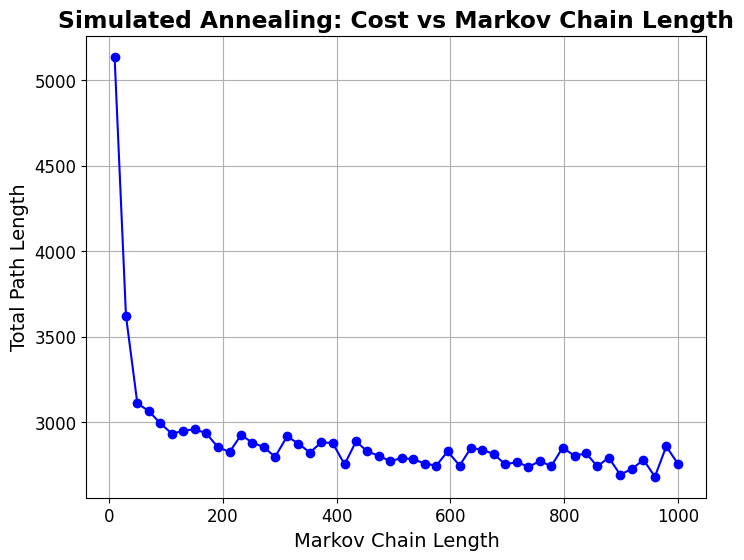

In [87]:
# Parameters
markov_lengths = np.linspace(10, 1000, 50, dtype=int)
initial_temp = 1000
cooling_rate = 0.995
max_iter = 5000

cost_markov = []
sol_markov = []

for markov_length in markov_lengths:
    best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "geometric_cooling_strategy", markov_length, max_iter, cooling_rate)
    sol_markov.append(best_solution)
    cost_markov.append(best_cost)

plt.figure(figsize=(8, 6))
plt.plot(markov_lengths, cost_markov, marker='o', color='blue')
plt.title("Simulated Annealing: Cost vs Markov Chain Length")
plt.xlabel("Markov Chain Length")
plt.ylabel("Total Path Length")
plt.grid(True)
plt.show()

Best Solution: [133, 132, 131, 130, 129, 128, 153, 154, 152, 155, 151, 150, 176, 175, 177, 149, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 196, 193, 194, 195, 197, 200, 201, 202, 203, 204, 205, 206, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 233, 234, 235, 232, 231, 236, 237, 230, 245, 238, 239, 240, 241, 242, 243, 244, 246, 249, 250, 229, 228, 227, 208, 207, 252, 251, 253, 256, 257, 255, 254, 248, 247, 277, 278, 2, 279, 1, 0, 4, 5, 3, 276, 275, 274, 8, 6, 7, 9, 10, 11, 14, 12, 13, 23, 22, 24, 21, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 59, 60, 117, 61, 62, 58, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 67, 68, 66, 69, 70, 71, 72, 73, 74, 76, 77, 75, 82, 81, 80, 78, 79, 92, 93, 94, 95, 96, 97, 98, 99, 100, 168, 101, 91, 90, 89, 108, 88, 87, 86, 83, 84, 65, 63, 64, 85, 115, 116, 114, 113, 112, 111, 110, 109, 107, 103, 102, 104, 105, 106, 173, 172, 170, 171, 169, 16

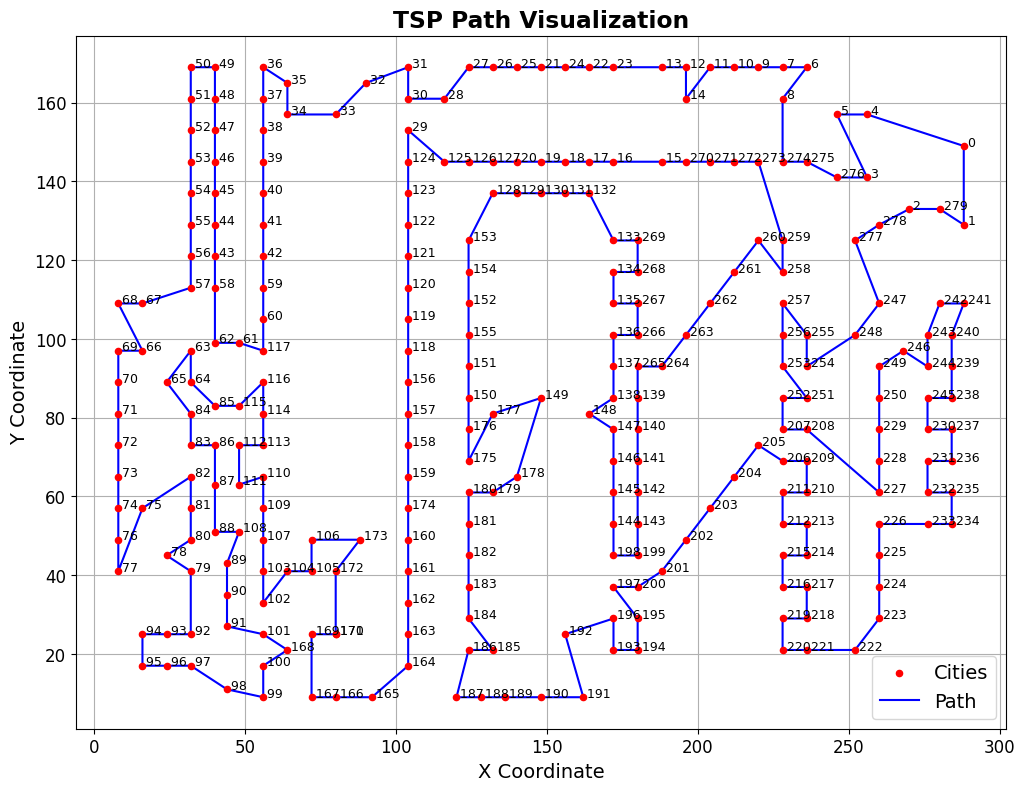

In [ ]:
# Optimal Parameters
initial_temp = 200
cooling_rate = 0.0001
markov_length = 605
max_iter = 100000

best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "exponential_cooling_strategy", markov_length, max_iter, cooling_rate)

print("Best Solution:", best_solution)
print("Best Cost:", best_cost)

plot_tsp_path(coord, best_solution)

In [ ]:
coord1 = read_tsp_file("eil51.tsp.txt")
coord2 = read_tsp_file("pcb442.tsp.txt")

dist_matrix1 = calculate_distance_matrix(coord1)
dist_matrix2 = calculate_distance_matrix(coord2)

cooling_rate = 0.0001

# Run the algorithm
best_solution1, best_cost1 = simulated_annealing(dist_matrix1, initial_temp, "exponential_cooling_strategy" , markov_length, max_iter, cooling_rate)
best_solution2, best_cost2 = simulated_annealing(dist_matrix2, initial_temp, "exponential_cooling_strategy" , markov_length, max_iter, cooling_rate)


# Output the results
print("Best Solution 51 cities:", best_solution1)
print("Best Cost:", best_cost1)

# Output the results
print("Best Solution 442 cities:", best_solution2)
print("Best Cost:", best_cost2)

NameError: name 'read_tsp_file' is not defined

In [ ]:
coord1 = read_tsp_file("eil51.tsp.txt")
coord2 = read_tsp_file("pcb442.tsp.txt")
coord3 = read_tsp_file("a280.tsp.txt")

dist_matrix51 = calculate_distance_matrix(coord1)
dist_matrix442 = calculate_distance_matrix(coord2)
dist_matrix280 = calculate_distance_matrix(coord3)

optimal1 = [
    1, 22, 8, 26, 31, 28, 3, 36, 35, 20, 2, 29, 21, 16, 50, 34, 30, 9, 49, 10,
    39, 33, 45, 15, 44, 42, 40, 19, 41, 13, 25, 14, 24, 43, 7, 23, 48, 6, 27,
    51, 46, 12, 47, 18, 4, 17, 37, 5, 38, 11, 32
]

optimal2 = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 53, 
    52, 51, 83, 84, 85, 381, 382, 86, 54, 21, 22, 55, 87, 378, 88, 56, 23, 24, 
    25, 26, 27, 28, 29, 30, 31, 32, 376, 377, 33, 65, 64, 63, 62, 61, 60, 59, 
    58, 57, 89, 90, 91, 92, 93, 101, 111, 123, 133, 146, 158, 169, 182, 197, 
    196, 195, 194, 181, 168, 157, 145, 144, 391, 132, 122, 110, 121, 385, 109, 
    120, 388, 131, 143, 156, 167, 180, 193, 192, 204, 216, 225, 233, 408, 409, 
    412, 413, 404, 217, 205, 206, 207, 208, 218, 219, 209, 198, 183, 170, 159, 
    147, 134, 124, 112, 436, 94, 95, 379, 96, 380, 97, 98, 384, 383, 113, 125, 
    135, 148, 160, 171, 184, 199, 210, 220, 226, 411, 410, 414, 237, 265, 437, 
    275, 423, 438, 272, 420, 268, 416, 264, 236, 263, 262, 261, 422, 419, 260, 
    259, 258, 257, 256, 255, 254, 253, 418, 417, 252, 251, 250, 415, 249, 248, 
    247, 246, 245, 244, 243, 242, 241, 407, 228, 235, 240, 267, 271, 270, 274, 
    277, 426, 280, 440, 308, 309, 283, 284, 310, 339, 311, 285, 286, 312, 340, 
    313, 287, 288, 314, 315, 316, 290, 289, 424, 421, 425, 291, 317, 318, 292, 
    293, 319, 320, 294, 295, 321, 322, 296, 278, 297, 323, 430, 429, 324, 298, 
    299, 300, 325, 326, 301, 302, 327, 328, 303, 304, 329, 330, 305, 306, 331, 
    332, 333, 432, 334, 307, 335, 336, 427, 337, 338, 375, 374, 373, 372, 371, 
    370, 369, 368, 345, 367, 366, 365, 431, 364, 363, 362, 344, 361, 360, 359, 
    435, 358, 357, 356, 434, 355, 354, 353, 343, 352, 351, 350, 349, 433, 348, 
    347, 346, 342, 341, 428, 282, 281, 279, 276, 273, 269, 266, 239, 238, 234, 
    227, 405, 406, 401, 400, 185, 172, 161, 149, 136, 126, 114, 103, 102, 441, 
    104, 115, 386, 127, 387, 389, 116, 138, 392, 152, 151, 137, 150, 162, 173, 
    186, 174, 396, 399, 187, 175, 211, 403, 221, 229, 212, 230, 222, 213, 200, 
    188, 176, 163, 393, 153, 139, 140, 128, 117, 105, 106, 107, 118, 129, 141, 
    154, 165, 164, 397, 177, 189, 201, 202, 402, 214, 223, 231, 232, 224, 215, 
    203, 190, 191, 398, 178, 179, 395, 394, 166, 155, 142, 390, 130, 119, 108, 
    439, 82, 50, 49, 81, 100, 80, 48, 47, 79, 78, 46, 45, 77, 99, 76, 44, 43, 
    75, 74, 42, 41, 73, 72, 40, 39, 71, 70, 38, 37, 69, 68, 36, 35, 67, 66, 34, 
    442
]

optimal3 = [
    1, 2, 242, 243, 244, 241, 240, 239, 238, 237, 236, 235, 234, 233, 232, 
    231, 246, 245, 247, 250, 251, 230, 229, 228, 227, 226, 225, 224, 223, 
    222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 207, 
    206, 205, 204, 203, 202, 201, 198, 197, 196, 195, 194, 193, 192, 191, 
    190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 176, 180, 179, 150, 
    178, 177, 151, 152, 156, 153, 155, 154, 129, 130, 131, 20, 21, 128, 127, 
    126, 125, 124, 123, 122, 121, 120, 119, 157, 158, 159, 160, 175, 161, 
    162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 171, 173, 174, 107, 
    106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 
    90, 89, 109, 108, 110, 111, 112, 88, 87, 113, 114, 115, 117, 116, 86, 
    85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 
    67, 66, 65, 64, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 
    44, 59, 63, 62, 118, 61, 60, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 
    32, 31, 30, 29, 28, 27, 26, 22, 25, 23, 24, 14, 15, 13, 12, 11, 10, 9, 8, 
    7, 6, 5, 4, 277, 276, 275, 274, 273, 272, 271, 16, 17, 18, 19, 132, 133, 
    134, 270, 269, 135, 136, 268, 267, 137, 138, 139, 149, 148, 147, 146, 
    145, 199, 200, 144, 143, 142, 141, 140, 266, 265, 264, 263, 262, 261, 
    260, 259, 258, 257, 254, 253, 208, 209, 252, 255, 256, 249, 248, 278, 
    279, 3, 280
]

optimal51 = [el-1 for el in optimal1]
optimal442 = [el-1 for el in optimal2]
optimal280 = [el-1 for el in optimal3]

optimal_cost51 = total_path_length(optimal51, dist_matrix51)
optimal_cost442 = total_path_length(optimal442, dist_matrix442)
optimal_cost280 = total_path_length(optimal280, dist_matrix280)

# Output the results
print("Optimal Cost:", optimal_cost51)
print("Optimal Cost", optimal_cost280)
print("Optimal Cost:", optimal_cost442)